# Segmentación de núcleos celulares en preparaciones microscópicas.

## Introducción

Una de las dificultades que presentan los softwares de microscopía en la detección de células es la segmentación, sobre todo en aquellas células que apenas existe espacio entre ellas. Una aproximación a la separación de células es segmentar primeramente los núcleos para posteriormente asociar el contenido citoplasmatico a su nucleo celular.

Primeramente, debemos tener un pipeline para la detección de núcleos. Pero, uno de los problemas que se suele presentar es la solapación parcial de dos o más células, en especial en aquellas preparaciones con alta celularidad. Dichas situaciones deben ser detectadas para poder independizar el análisis a cada célula.

### Detección de núcleos.

Generalmente en las tinciones de fluorescencia se suele marcar el DNA nuclear con colorantes fluorescentes con banda de emisión en azul-cian. Los colorantes de flourescencia del DNA más utilizados son los colorantes: Hoechst y DAPI. 

El colorante DAPI tiene un máximo de absorción en el UV a 358nm, y su máximo de emisión está en 461nm (azul-cian).

Los colorantes de Hoechst 33342 y Hoechst 33258, se excitan en el UV a 350nm y emiten luz azul-cian con un máximo a 461nm si están intercaladas en DNA y a 510-540nm las moleculas que no estén unidas. Debido a la elevada varianción entre la banda de excitación y la de emisión (variación de Stokes) hace que el colorante de Hoehst sea muy útil en experimentos en los que múltiples flouroforos son utilizados. Las ventajas de utilizar colorantes Hoechst frente a DAPI son que presenta menos toxicidad -dando una mayor viabilidad a las células marcadas, pudiéndose utilizar en células vivas con la misma efectividad- y una mayor permeabilidad celular - debido a la apolaridad del grupo etilo de los colorantes Hoechst- por lo que no es necesaria una alta concentración.
 

Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) http://dx.doi.org/10.7717/peerj.453 

## 1. Procesado de imágenes

Las imágenes presentadas han sido obtenidas por un microescopio confocal con lentes de 60x y las preparaciones son de cultivos celulares de glía de rata marcados los núcleos con Hoescht. Las imágenes han sido guardadas con resolución 1024x1024.


#### Librerias de Python utilizadas en el procesado de imágenes:

- *scikit-image* : es una colección de algoritmos para el procesado de imágnes
- *os*: módulo que presenta funciones con interfaz con el sistema operativo
- *matplotlib*: librería para la producción de gráficas permitiendo la interactividad.
- *mahotas*: libraría para el procesado de imágenes y la visión computacional.
- *numpy*: librería con amplios recursos para el álgebra lineal.
- *IPython*: herramienta para la computación interactiva.

In [1]:
# Cargamos librerias a utilizar
import skimage
import os
import mahotas as mh
import numpy as np
from ipywidgets import interact, fixed
import mahotas as mh

def fill_contours(arr):
    return (np.maximum.accumulate(arr,1) & np.maximum.accumulate(arr[:,::-1],1)[:,::-1])

#### Imágenes de microscopía

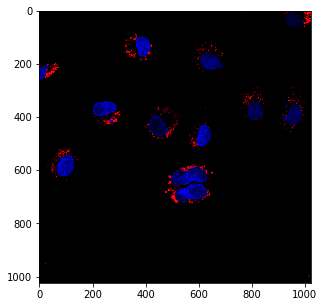

In [18]:
from skimage import io, color
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
image = "./Data/Image_B.tif"
cell_image = io.imread(image)

ax.imshow(cell_image)

El proyecto presentado se basa en la segmentación de núcleos celulares, por tanto, sólo nos centraremos en éstos. Por otra parte, las imágenes están representadas mediante en una matriz (n x m x c), siendo "n" las filas, "m" las columnas y "c" los canales de color: rgb (rojo, verde y azul). Dado que los núcleos celulares están marcados en azul, es sencillo el aislamento del color mediante la selección  del canal azul.

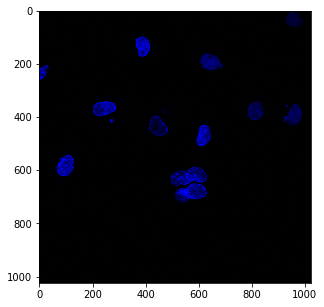

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
image_blue = cell_image[:,:,[1,1,2]]
ax.imshow(image_blue)

## 2.Técnicas de segmentación:

Las técnicas de segmentación de imágenes se fundamentan en el proceso de partición de imagenes digitales en diferentes segmentos formados por pixels que comparten similares caracteristicas frente al fondo. La utilidad de la segmentación es simplificar y caracterizar la representación de una imagen en objetos más sencillos de ser analizados. Por tanto la segmentación de imágenes es utilizada para localizar objetos y límites.

El resultado de la segmentación es un conjunto de segmentos que colectivamente cubren toda la imagen. Cada uno de los pixeles de una región tienen características similares, como el color, la intensidad y textura. Mientras que en las regiones vecinas a dicha región presentan caracteristicas diferenciales.

Existen diferentes métodos para realizar la segmentación como son: *thresholding*, *clustering*, métodos basados en compresión, métodos basados en histogramas, détección de límites, partición por grafos...

Para el caso particular de la detección y segmentación de núcleos celulares los métodos más utilizados han sido el método límite (*threshold*) y el método por inundación (*watershed*).


### Método *threshold* mediante el uso de histogramas:

El método más simple de segmentación es el método *thresholding*, ya que convierte una imagen de blanco y negro en una imagen binaria (por encima o debajo del límite). La clave de este método es seleccionar un valor límite adecuado. 

Existen varios algoritmos de segmentación de imagenes mediante la utilización de un valor límite utilizando el histograma de intensidades. Los métodos más utilizados son: método de Li, método de Yen, método mínimo, isodata y  método de Otsu.


El *pipeline* de detección de núcleos mediante segmentación por el método de Li es:

Number of cells: 11


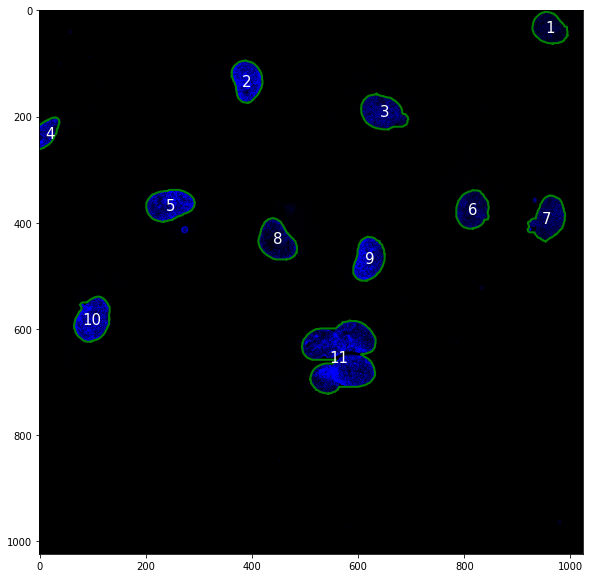

In [4]:
#Librerias utilzadas
from skimage.filters import try_all_threshold
from skimage.filters import threshold_yen, threshold_li, threshold_isodata, threshold_minimum, threshold_otsu 
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import matplotlib.patches as mpatches

def fill_contours(arr):
    """Función para rellenar huecos internos dentro de un objeto detectado"""
    return (np.maximum.accumulate(arr,1) & np.maximum.accumulate(arr[:,::-1],1)[:,::-1])

fig, ax = plt.subplots(figsize=(10, 10))

#Convertir la imágen en escala de grises
image_grey = color.rgb2gray(cell_image[:,:,2])

# Detectamos el límite propuesto por el algoritmo de Otsu
thresh = threshold_li(image_grey)

#Obtenemos los objetos detectados en la imagen eliminando el fondo -utilizando el valor límite- y uniendo huecos de un pixel para obtener continuidad.
bw = closing(image_grey > thresh, square(3))

# Etiquetamos los objetos detectados
label_image = label(bw)
region_image = label_image.copy()

#Contamos el número de nucleos detectados
cell_num=1

for region in regionprops(label_image, image_grey):
    #Sólo detectamos aquellos regiones con un mínimo de pixeles para poder ser considerado un núcleo
        if region.area >= 500:
            #Aislamos las regiones detectadas
            region_image[:,:] = 0
            region_image[label_image == region.label] = region.label
            #Rellenamos los posibles huecos internos
            region_image=fill_contours(region_image)
            #Se detectan los contornos de la región
            contours=skimage.measure.find_contours(region_image,0.5)
            #Marcamos en la imagen los contornos para la región detectada
            for n, contour in enumerate(contours):
                ax.plot(contour[:,1], contour[:,0],'g', linewidth=2)
            #Anotación de cada región 
            minr, minc, maxr, maxc = region.bbox
            ax.text(0.5*(minc+maxc),0.5*(minr+maxr), str(cell_num), horizontalalignment="center", verticalalignment="center", fontsize=15, color="white")
            cell_num+=1


ax.imshow(image_blue)
print("Number of cells: {}" .format(cell_num-1))

Con el pipeline desarrollado se detectan los nucleos celulares por segmentanción y estos serán catalogados como núcleos siempre que la región considerada tenga un mínimo de pixels, es decir es necesario un volumen límite para poder ser considerado núcleo celular.

En la figura siguiente se realiza un estudio de los diferentes métodos de segmentacion límite. Se puede observar en el histograma de intensidades qué valor límite se obtiene por cada algoritmo.En el histograma de intensidades la **x** representa la intesidad de color por pixel -tomando valores entre 0 y 255- e **y** la frecuencia relativa de una determinada intensidad en toda la imagen.

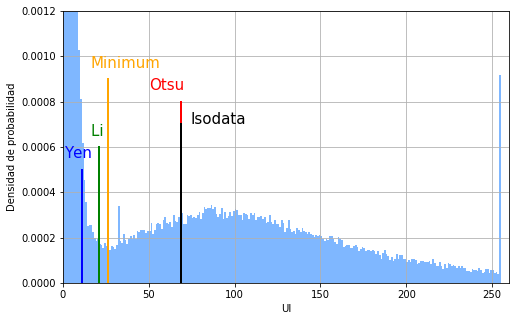

In [5]:
# Make regular histogram
ib_1d = image_grey.ravel()
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=[8,5])
a,b,c=ax.hist(ib_1d, bins=255, density= True, alpha=0.5, color="#0070FF")
plt.plot([threshold_otsu(image_grey), threshold_otsu(image_grey)], [0, 0.0008],"red", lw=2)
plt.text(50,0.00085, 'Otsu', fontsize=15, color="red")
plt.axis([0, 260, 0, 0.0012])

plt.plot([threshold_li(image_grey), threshold_li(image_grey)], [0, 0.0006],"green", lw=2)
plt.text(threshold_li(image_grey)-5,0.00065, 'Li ', fontsize=15, color="green")

plt.plot([threshold_yen(image_grey), threshold_yen(image_grey)], [0, 0.0005],"blue", lw=2)
plt.text(threshold_yen(image_grey)-10,0.00055, 'Yen', fontsize=15, color="blue")

plt.plot([threshold_isodata(image_grey), threshold_isodata(image_grey)], [0, 0.0007],"black", lw=2)
plt.text(threshold_isodata(image_grey)+5,0.0007, 'Isodata', fontsize=15, color="black")

plt.plot([threshold_minimum(image_grey), threshold_minimum(image_grey)], [0, 0.0009],"orange", lw=2)
plt.text(threshold_minimum(image_grey)-10,0.00095, 'Minimum', fontsize=15, color="orange")


plt.grid(True)
#Anotación
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlabel("UI")


plt.show()



El algoritmo Otsu de segmentación de objetos es bastante agresivo en la segmentación. Ésto es debido a que una de las limitaciones del método de Otsu es la segmentación de objetos con amplias varianzas de intensidad. En el caso de la segmentación de nucleos la varianza de las intensidades de nucleos es muy amplia, y por tanto, el algoritmo de Otsu no es capaz de encontrar el mínimo entre el ruido de fondo y la distribución de intensidades de los objetos a segmentar.

Los resutados obtenidos en la utilización de los diferentes algoritmos en 10 imágenes de microscopia. 

| Algoritmo | Areas detectadas | Nucleos detectados correctamente | Nucleos no separados|
|----|----|----|----|
|Otsu|198|193|5|
|Yen|203| 192|11|
|Isodata|199| 194|5|
|Li|201|193|8|
|Minimum|200|192|8|


En la imagen de más abajo se puede observar el resultado en la utilización de diferentes métodos de *thresholding*.

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


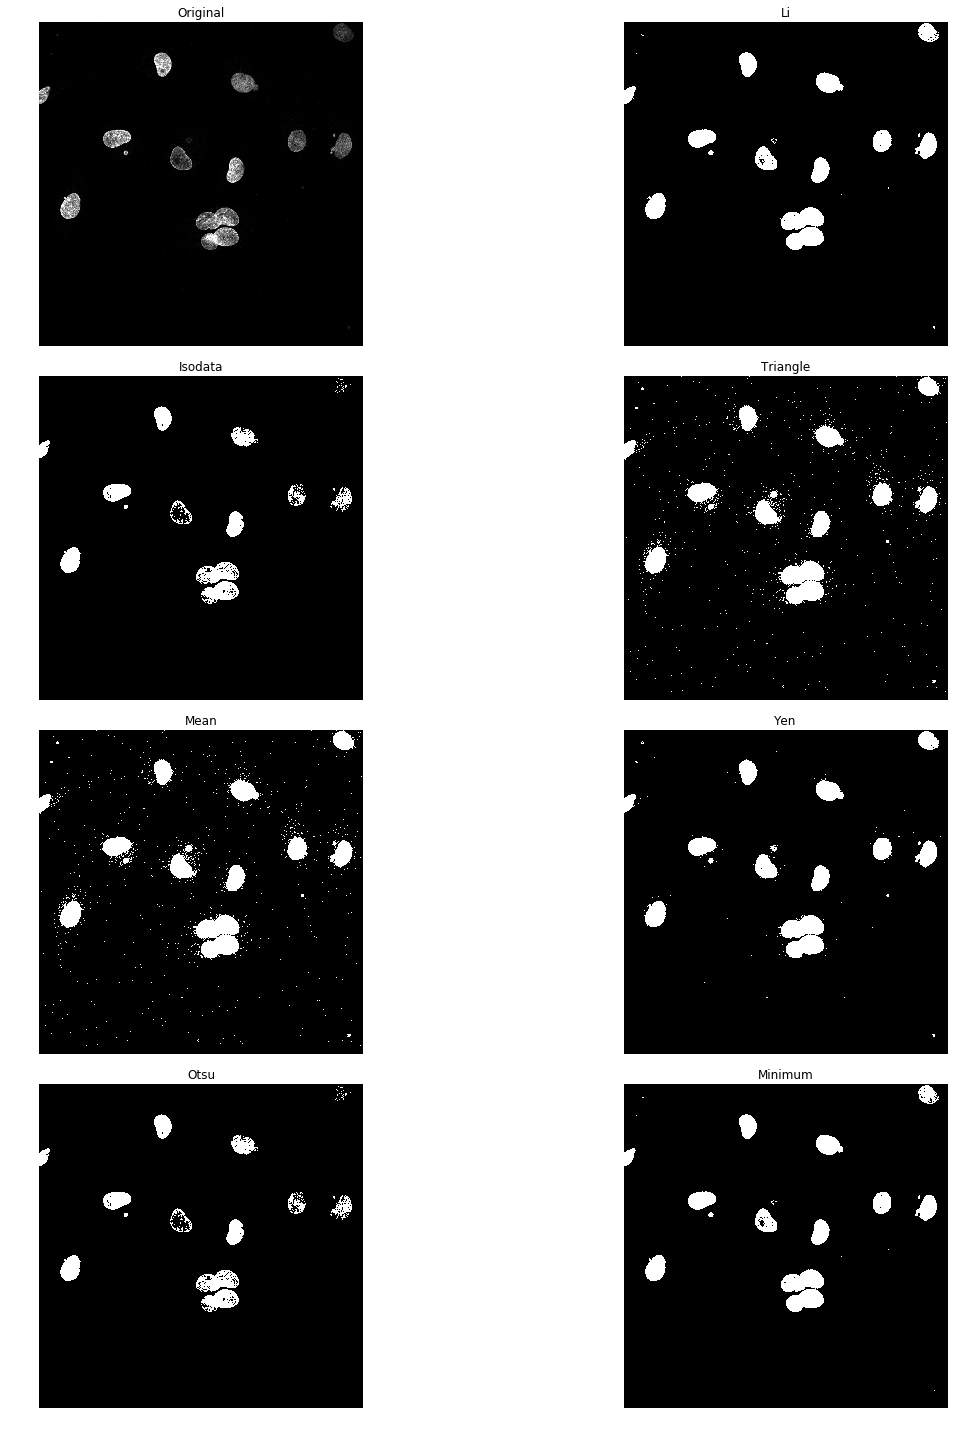

In [6]:

fig, ax = try_all_threshold(image_grey, figsize=(20, 20), verbose=False)
plt.show()

Se puede observar como los diferentes métodos de *threshold* presentan diferentes resultados. En general cuanto más bajo se ponga el límite - por ejemplo el algoritmo de Yen- menos ruido de fondo eliminaremos -detectando aquellos nucleos que presenten baja intensidad-, pero existe una mayor probabilidad de que un area segmentada presente multiples núcleos. Por otra parte, si ponemos el límite muy alto reduciremos el ruido de fondo mejorando la separación de nucleos a costa de perder detección de nucleos con baja intensidad. Mientras que el algoritmo que encuentra el mínimo de la función densidad da un resultado intermedio entre los dos extremos anteriores.

Idealmente se requiere detectar todos los núcleos posibles pero sin afectar a la efectividad a su separación. Dado que no es posible llevar a cabo una separación perfecta de los nucleos utilizando un valor límite de intensidad, se deberá de utilizar una herramienta ulterior para poder llevar a cabo la separación. Por ello, en el siguinte método que se presenta -el método de *watershed*- se intentará mejorar la especificidad en la segmentación.

### Método por transformada *watershed*

La transofrmada de *watershed* representa a la imagen como una topografía, la cual será inundada a partir de sus valles (mínimos) hasta alacanzar las cumbres de las montañas más altas (máximos). Por tanto, como resultado se obtendrá una imagen binaria. Formada por una parte por la superficie de la inundación -considerada como fondo- y por otra parte la superficie que está por encima del nivel de agua -considerada como señal-.

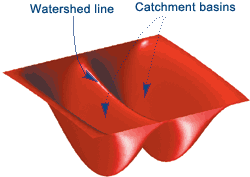

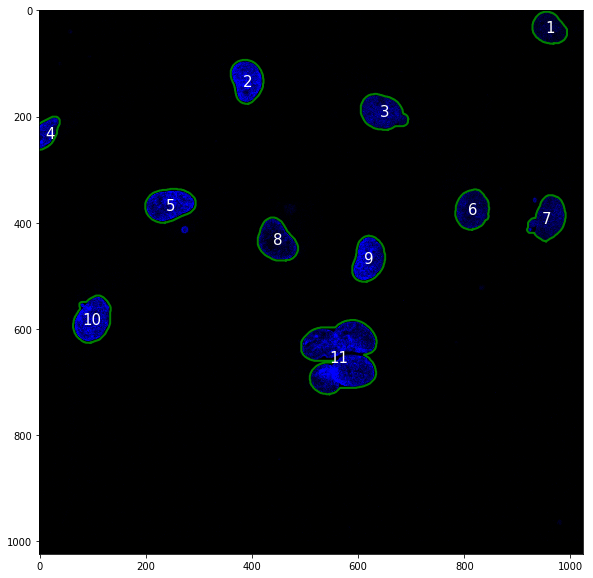

In [7]:

fig, ax = plt.subplots(figsize=(10, 10))
imgf = skimage.filters.gaussian(cell_image[:,:,2], 2.)
T_yen = threshold_li(imgf)
bin_image = imgf > T_yen
# Etiquetamos los objetos detectados
label_image = label(bin_image)
#Contamos el número de nucleos detectados
region_image = label_image.copy()

cell_num=1

for region in regionprops(label_image, image_grey):
        if region.area >= 500:#Sólo detectamos aquellos regiones de color azul con un mínimo de pixeles para poder ser considerado un núcleo
            region_image[:,:] = 0
            region_image[label_image == region.label] = region.label
            region_image=fill_contours(region_image)
            contours=skimage.measure.find_contours(region_image,0.5)
            for n, contour in enumerate(contours):
                ax.plot(contour[:,1], contour[:,0],'g', linewidth=2)
            minr, minc, maxr, maxc = region.bbox
            ax.text(0.5*(minc+maxc),0.5*(minr+maxr), str(cell_num), horizontalalignment="center", verticalalignment="center", fontsize=15, color="white")
            cell_num+=1


ax.imshow(image_blue)



La desventaja del método de *watershed* es que es muy sensible a la presencia de mínimos locales. De este modo,  si la imagen presenta un elevado ruido de fondo ésto afectará a la segmetación. El método puede ser afinado mediante la variable sigma. Dicha varaible utiliza un filtro gaussiano para "alisar" la imagen y por tanto eliminar mínimos locales. 

En la siguiente figura se puede comprobar como modificando la variable sigma cambia el patrón de segmentación. Cuanto más alto es sigma más confiaza existe de obtener una región que presente un máximo, aunque se obtienen menos casos. Cuanto más bajo es sigma se obtendrán mayor cantidad de regiones que presentan máximos locales, pero obteniendo mayor cantidad de falsos positivos.

In [8]:
img=cell_image[:,:,2]

#Se puede modificar el valor de sigma para modificar las segmentación watershed
@interact(sigma=(10.,30.))

def check_sigma(sigma):
    dnaf = skimage.filters.gaussian(img.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(dnaf))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    plt.imshow(mh.as_rgb(np.maximum(255*maxima, dnaf), dnaf, img > T_yen))



interactive(children=(FloatSlider(value=20.0, description='sigma', max=30.0, min=10.0), Output()), _dom_classes=('widget-interact',))

Para realizar la segmentación *watershed* tenemos que detectar los máximos de la imagen.

/usr/local/lib/python3.5/dist-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


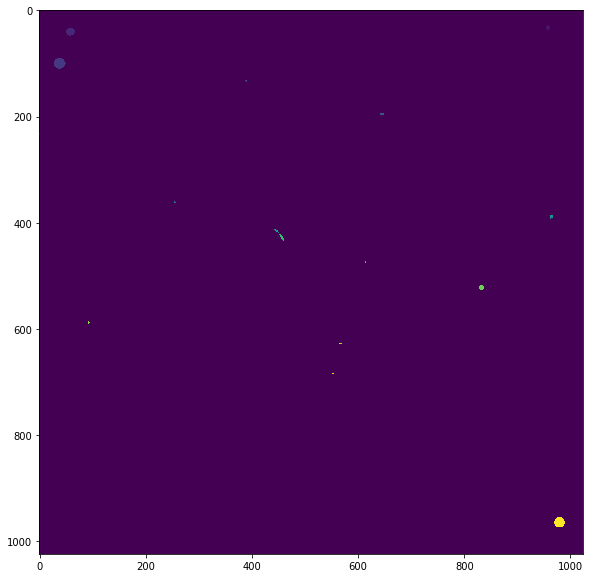

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sigma = 12
dnaf = mh.gaussian_filter(img.astype(float), sigma)
maxima = mh.regmax(mh.stretch(dnaf))
maxima,_= mh.label(maxima)
plt.imshow(maxima)

El siguiente paso es calcular la distancia de cada punto a la zona inundada más cercana.

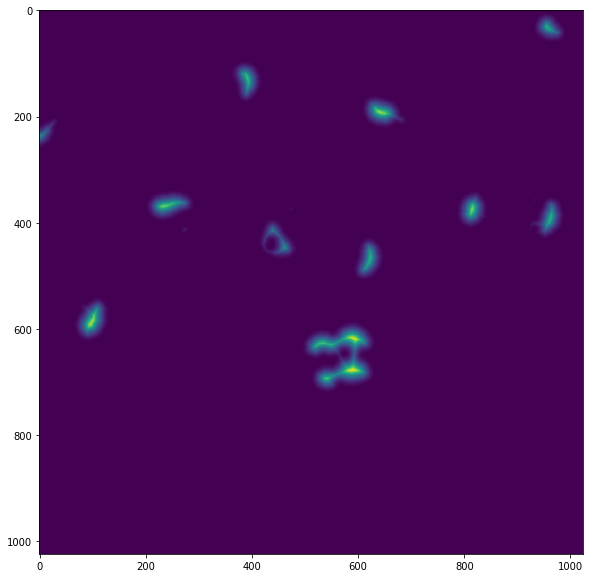

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

dist = mh.distance(bin_image)
plt.imshow(dist)

Teniendo en cuenta los máximos locales y la matriz de distancias podemos obtener las regiones candidatas a ser núcleos celulares.

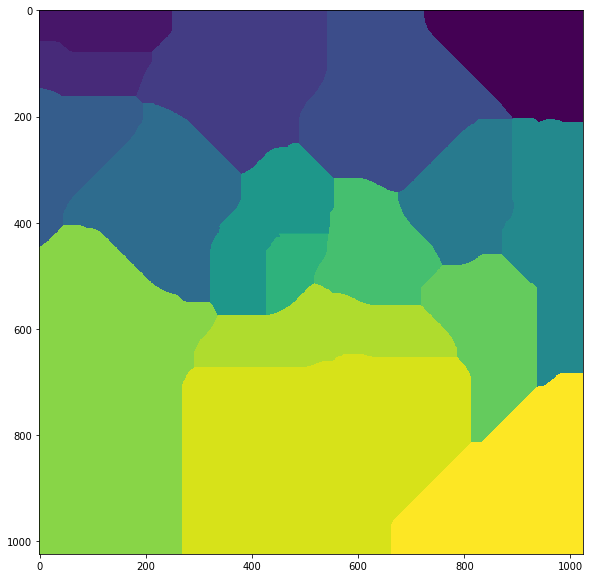

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

dist = 255 - mh.stretch(dist)
watershed = mh.cwatershed(dist, maxima)
plt.imshow(watershed)

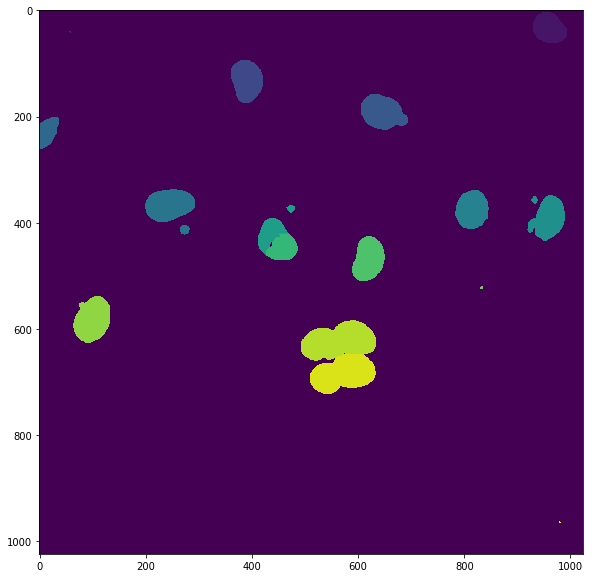

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

watershed *= bin_image
plt.imshow(watershed)

Number of cells: 13


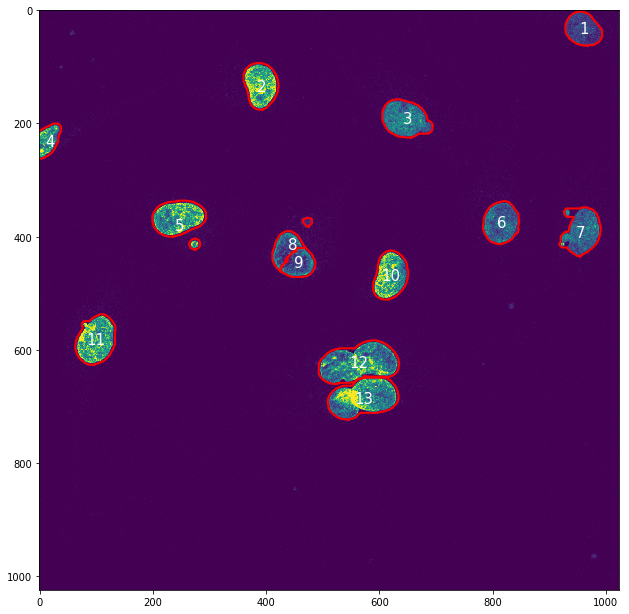

In [17]:

fig, ax = plt.subplots(figsize=(10.6666, 10.6666))

sizes = mh.labeled.labeled_size(watershed)
min_size = 500
filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)

labeled,nr_objects = mh.labeled.relabel(filtered)

region_image = labeled.copy()

cell_num=1

for region in regionprops(labeled, image_grey):
    region_image[:,:] = 0
    region_image[labeled == region.label] = region.label
    region_image=fill_contours(region_image)
    contours=skimage.measure.find_contours(region_image,0.5)
    for n, contour in enumerate(contours):
        ax.plot(contour[:,1], contour[:,0],'r', linewidth=2)
    minr, minc, maxr, maxc = region.bbox
    ax.text(0.5*(minc+maxc),0.5*(minr+maxr), str(cell_num), horizontalalignment="center", verticalalignment="center", fontsize=15, color="white")
    cell_num+=1


ax.imshow(image_grey)
print("Number of cells: {}".format(nr_objects))

Se puede comprobar como el método de watershed ha podido separar las regiones 12 y 13 (que no podía separar el método de *Threshold* de Li). Pero por otra parte, las regiones 12 y 13 están constituidas por dos células cada una, y además, se ha separado una única célula en dos regiones (8 y 9).Por tanto, se puede comprobar como fijar un único valor de la variable sigma puede provocar una sobre-segmentación y una infrasegmentación en la misma imagen.